## Imports

In [2]:
# utils
import os
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

# metrics
from utils import config
from utils.reader import read_file_yaml

np.random.seed(0)

## Parameters

In [6]:
path_root = (
    PROJECT_DIR
    / "results"
)
path_conf = (
    PROJECT_DIR
    / "conf"
)
file_path_parameters = (
    path_conf 
    / "parameters.yml"
)
path_outputs = (
    PROJECT_DIR
    / "outputs"
)
params = read_file_yaml(file_path_parameters)
if not os.path.exists(path_outputs):
    os.makedirs(path_outputs)
    
file_path_simulation_plot = (
    path_outputs
    / params["outputs"]["simulation_random"]["filepath"]
)
    
file_path_plot_i_dataset = (
    path_outputs
    / params["outputs"]["simulation_random"]["data_filepath"]
)
n_random = np.sort([int(i.replace("random_n",""))for i in os.listdir(path_root) if ".placehold"not in i])
path_random = [
    "random_n"+str(i) for i in n_random
]
path_results = [path_root / i for i in path_random]

In [7]:
under_line = "\n{}\n"
title_part_n2 = "PROJECT_DIR: [ {} ]".format(PROJECT_DIR)
title_part_n3 = under_line.format(
    "".join(["-"]*len(title_part_n2))
)
title_part_n1 = under_line.format(
    "".join(["-"]*len(title_part_n2))
)
print(title_part_n1 + title_part_n2 + title_part_n3)


----------------------------------------------------
PROJECT_DIR: [ /home/manuel/aaai-claire-clustering ]
----------------------------------------------------



## Read

In [8]:
parameters = read_file_yaml(file_path_parameters)

In [9]:
path_metrics = []
for name, url in zip(path_random, path_results):
    _path_metrics = [
        [f"{name}_{dataset}", os.path.getmtime(url / dataset / "metrics" / "metrics.csv")]
        for dataset in os.listdir(url)
    ]
    path_metrics = path_metrics + _path_metrics
init = int(pd.DataFrame(path_metrics).sort_values(1).iloc[0,0].split("_")[1][1:])

In [10]:
metrics = {
    name: {
        dataset: pd.read_csv(
            url / dataset / "metrics" / "metrics.csv",
            index_col = 0
        ) for dataset in os.listdir(url)
    }
    for name, url in zip(path_random, path_results)
}

## Concat all results

In [90]:
data = (
    metrics[f"random_n{init}"]["aniso"]
    .T
    .filter(regex = "^(?!.*random_model)")
    .T[["abilities"]]
    .reset_index()
)

data.rename(columns = {
    "abilities": f"n{init}_aniso",
    "index": "model"
}, inplace = True)


for random_n, content_n in metrics.items():
    for name, content_dataset in content_n.items(): 
        if (random_n == f"random_n{init}")and(name == "aniso"):
            continue
        tmp = (
            content_dataset
            .T
            .filter(regex = "^(?!.*random_model)")
            .T[["abilities"]]
            .reset_index()
        )
        
        tmp.rename(columns = {
            "abilities": "n{}_{}".format(
                random_n.replace("random_n",""),
                name
            ),
            "index": "model"
        }, inplace = True)

        data = data.merge(tmp, on = ["model"], indicator = True).drop("_merge", axis = 1)
#data.set_index("model", inplace = True)

In [91]:
data

,model,n1_aniso,n1_no_structure,n1_noisy_circles,n1_blobs,n1_varied,n1_noisy_moons,n2_aniso,n2_no_structure,n2_noisy_circles,...,n12_varied,n12_noisy_moons,n13_aniso,n13_no_structure,n13_noisy_circles,n13_blobs,n13_varied,n13_noisy_moons,n14_aniso,n14_blobs
0,optimal_clustering,0.504888,0.514940,0.499900,0.511251,0.519574,0.489235,0.505456,0.527040,0.501114,...,0.529762,0.510970,0.513535,0.514373,0.513452,0.496396,0.530161,0.512147,0.514639,0.521349
1,spectral_clustering_n_clusters_1_eigen_solver_...,0.502774,0.505888,0.493156,0.511251,0.515359,0.479095,0.503463,0.517709,0.494632,...,0.525793,0.504044,0.511437,0.504117,0.508675,0.451906,0.526167,0.505394,0.512472,0.521349
2,kernel_kmeans_n_clusters_1_kernel_gak_random_s...,0.501858,0.446666,0.486427,0.510643,0.504867,0.483912,0.502617,0.473162,0.488127,...,0.521932,0.507091,0.511029,0.435358,0.503832,0.496153,0.522620,0.508353,0.512141,0.521075
3,spectral_clustering_n_clusters_8_eigen_solver_...,0.500254,0.446666,0.486454,0.511251,0.462232,0.483759,0.501167,0.473162,0.488151,...,0.492828,0.506981,0.510351,0.435358,0.503850,0.496396,0.494197,0.508246,0.511455,0.521349
4,kmeans_n_clusters_3,0.498667,0.504003,0.477683,0.511251,0.515706,0.468642,0.499510,0.514554,0.480658,...,0.526066,0.495925,0.508504,0.504036,0.497319,0.496396,0.526476,0.497623,0.509332,0.521349
5,dbscan_eps_0_3_min_samples_2,0.497116,0.503196,0.479523,0.511251,0.515815,0.469402,0.498104,0.513431,0.482192,...,0.525909,0.496799,0.507572,0.503930,0.499175,0.496396,0.526313,0.498114,0.508376,0.521349
6,kmeans_n_clusters_2,0.492145,0.496134,0.470258,0.436600,0.490475,0.472034,0.492549,0.513265,0.473181,...,0.501937,0.498492,0.496355,0.490416,0.491979,0.459207,0.502298,0.499932,0.497014,0.466752
7,dbscan_eps_0_4_min_samples_2,0.491977,0.510030,0.484816,0.491728,0.515193,0.468608,0.493146,0.517449,0.486806,...,0.527570,0.495965,0.506735,0.512918,0.502235,0.489301,0.528081,0.497063,0.507436,0.513403
8,spectral_clustering_n_clusters_7_eigen_solver_...,0.490827,0.446666,0.467160,0.511251,0.516340,0.470031,0.491323,0.473162,0.470494,...,0.526593,0.497034,0.495655,0.435358,0.489463,0.496396,0.526979,0.498482,0.496304,0.521349
9,spectral_clustering_n_clusters_3_eigen_solver_...,0.490016,0.499818,0.494653,0.393928,0.467894,0.473245,0.492008,0.501027,0.495929,...,0.499698,0.499281,0.508052,0.509850,0.509954,0.481455,0.501153,0.500806,0.509169,0.461356


In [85]:
tmp.head()

,model,n14_blobs
0,optimal_clustering,0.521349
1,kmeans_n_clusters_3,0.521349
2,dbscan_eps_0_3_min_samples_2,0.521349
3,spectral_clustering_n_clusters_8_eigen_solver_...,0.521349
4,spectral_clustering_n_clusters_7_eigen_solver_...,0.521349


In [58]:
data

,model,n1_aniso
0,optimal_clustering,0.504888
1,spectral_clustering_n_clusters_1_eigen_solver_...,0.502774
2,kernel_kmeans_n_clusters_1_kernel_gak_random_s...,0.501858
3,spectral_clustering_n_clusters_8_eigen_solver_...,0.500254
4,kmeans_n_clusters_3,0.498667
5,dbscan_eps_0_3_min_samples_2,0.497116
6,kmeans_n_clusters_2,0.492145
7,optics_min_samples_7_xi_0_1_min_cluster_size_0_2,0.492049
8,dbscan_eps_0_4_min_samples_2,0.491977
9,spectral_clustering_n_clusters_7_eigen_solver_...,0.490827


In [29]:
datasets = {}
for i in config.file_names:
    datasets[i] = data.filter(regex = r"{}".format(i))
    datasets[i].columns = datasets[i].columns.str.replace("_"+i, "")

## Plots

In [13]:
models = list(config.models.keys())+["average_model", "optimal_clustering"]
gray_scale = [str(i/len(models)) for i in range(1, len(models))]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(models)))
markers = list(mlines.Line2D.markers.keys())

_params = {
    _model: {
        "color": colors[_idx],
        "marker": markers[_idx],
        "linestyle": '--' 
    } for _idx, _model in enumerate(models)
}
handler_lines = [
    Line2D([], [], 
           color = param["color"],
           linestyle = param["linestyle"],
           marker = param["marker"]) for param in _params.values()
    ]

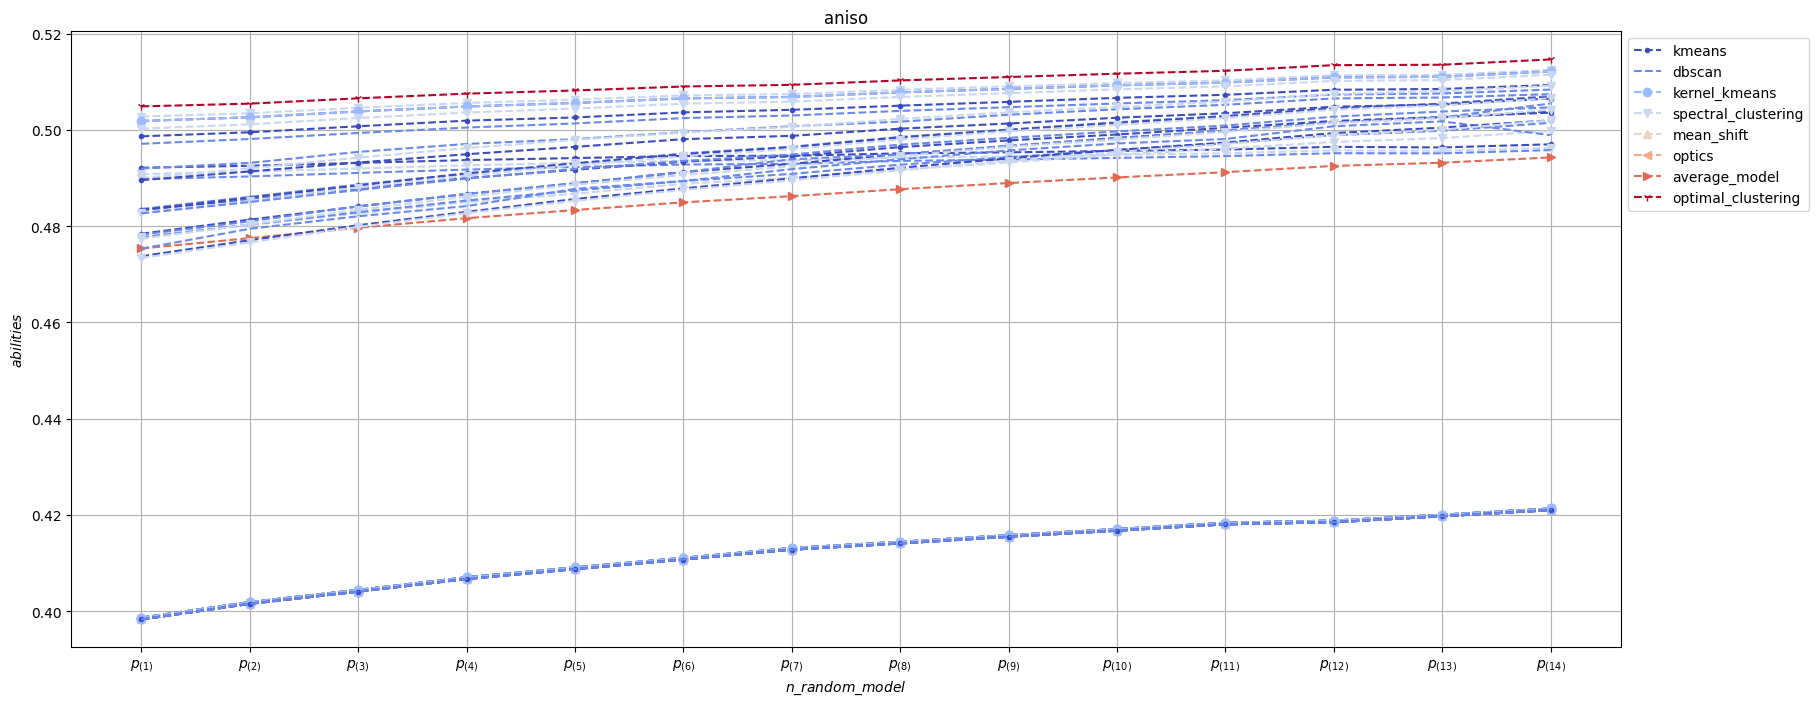

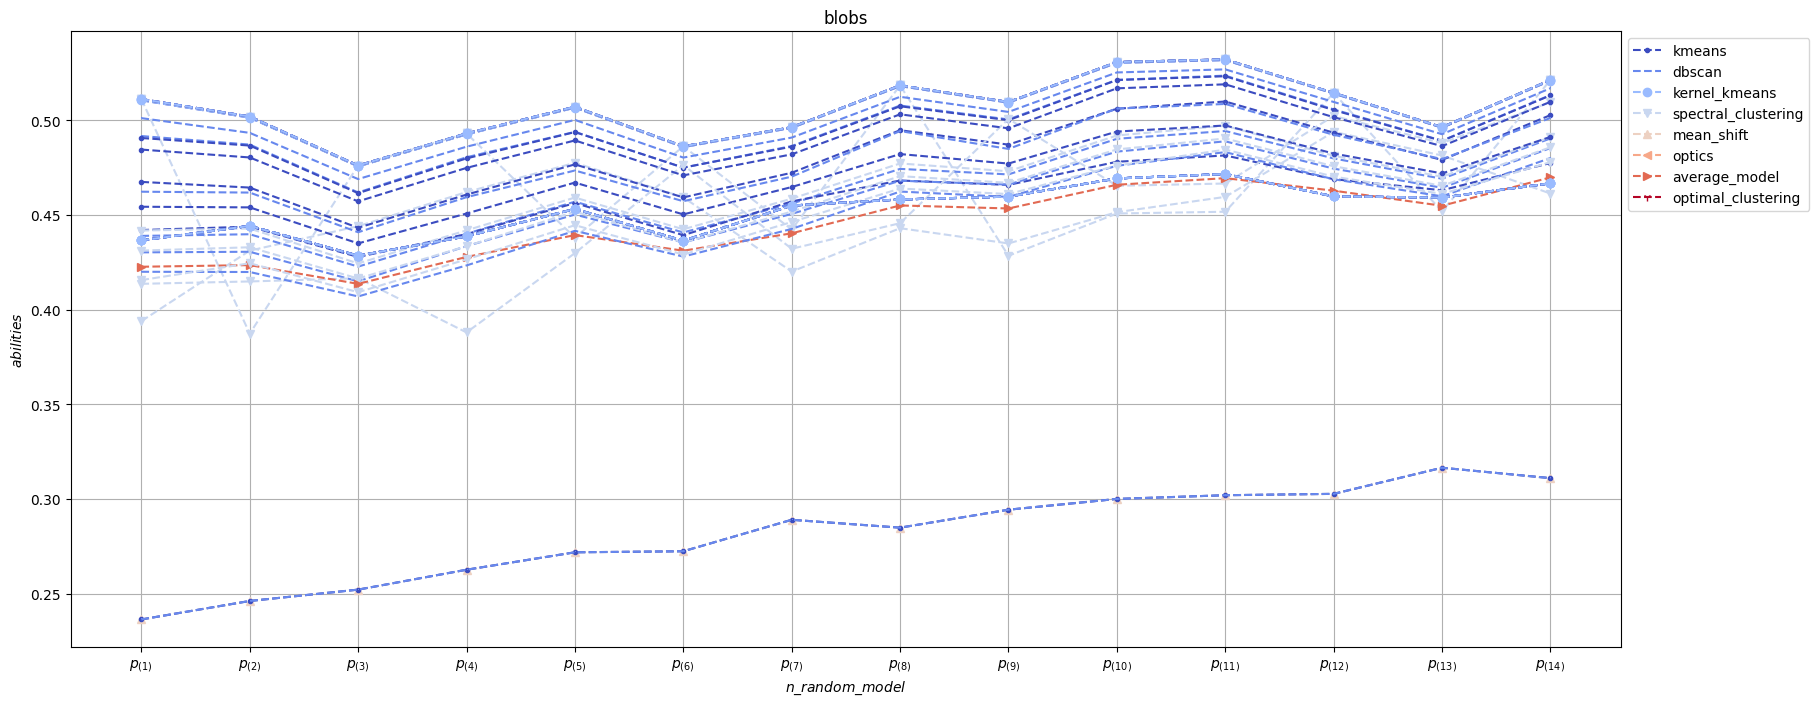

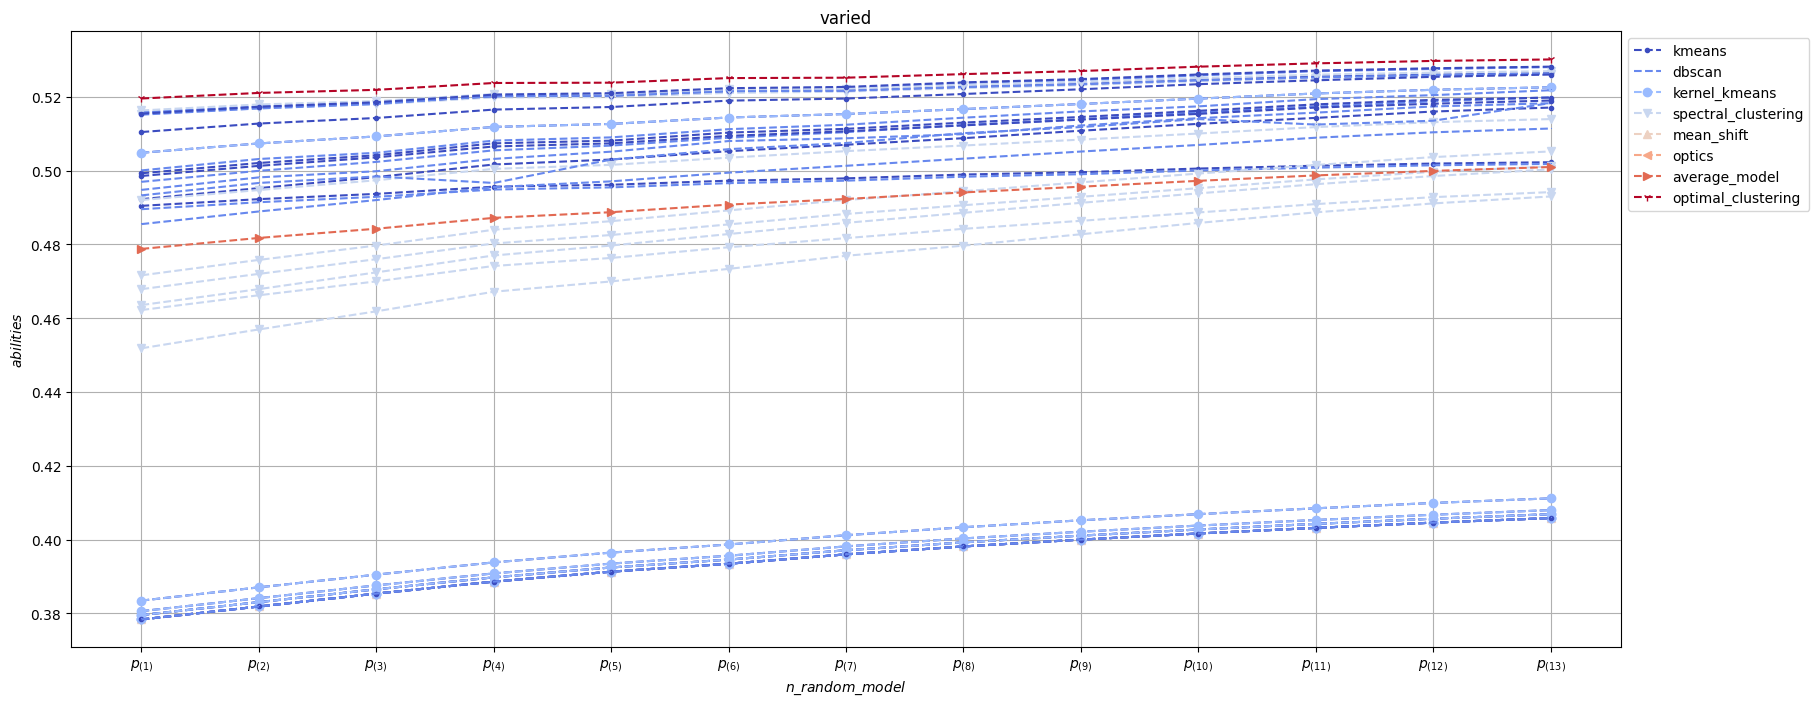

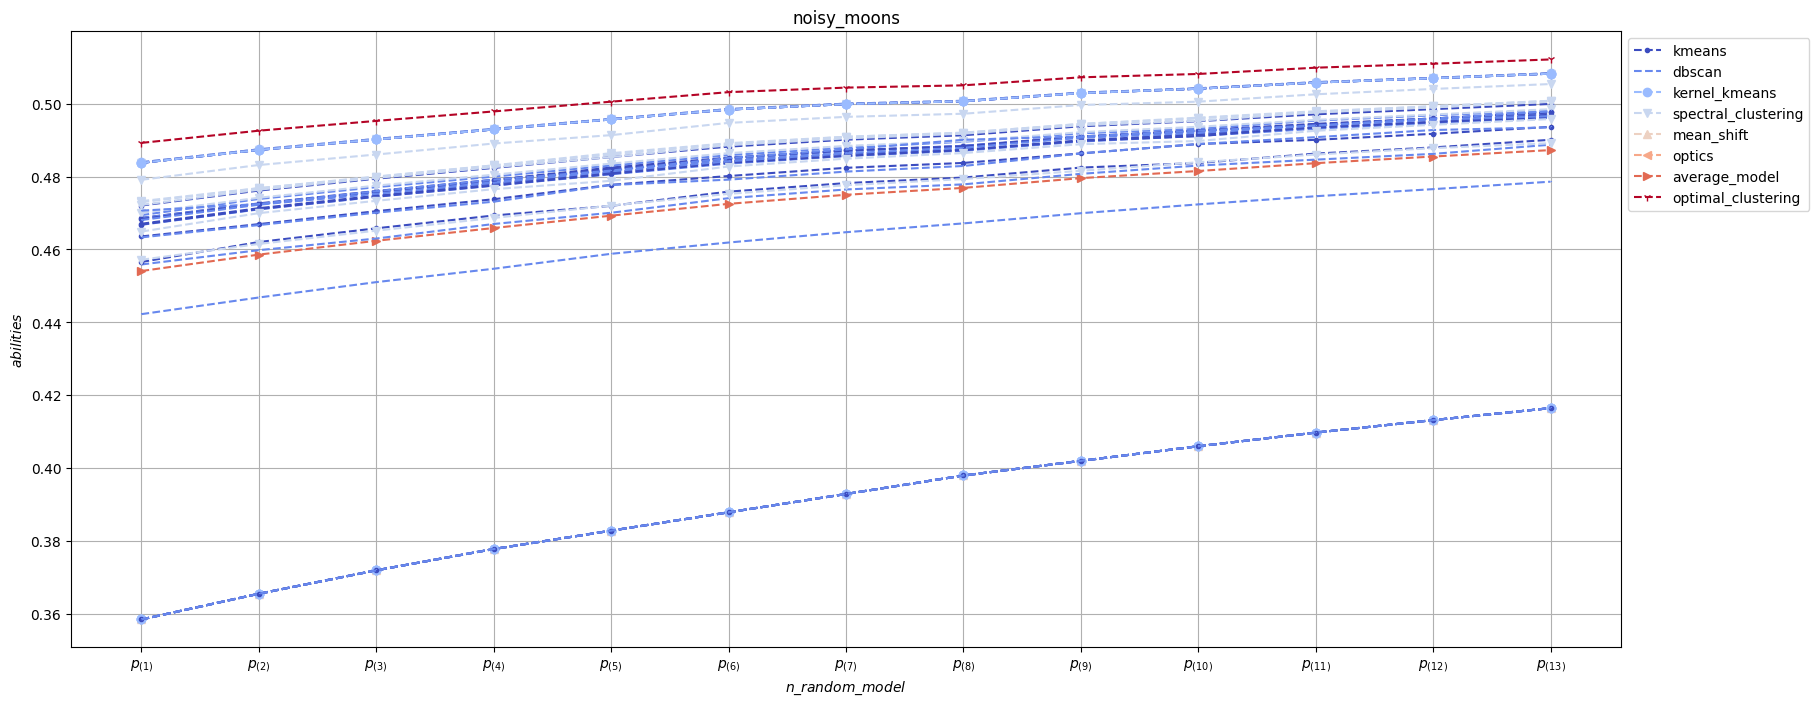

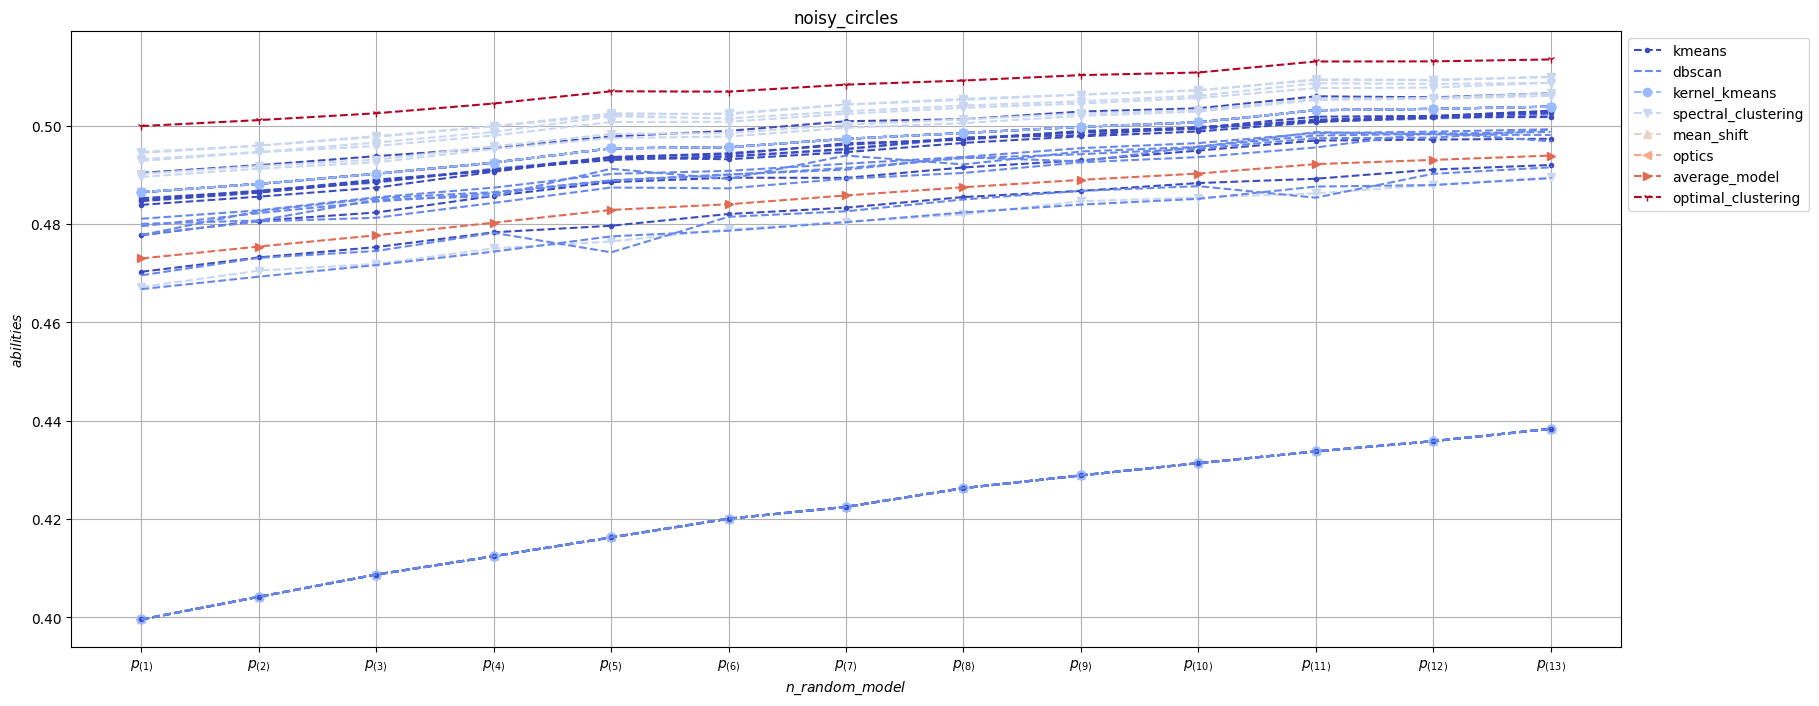

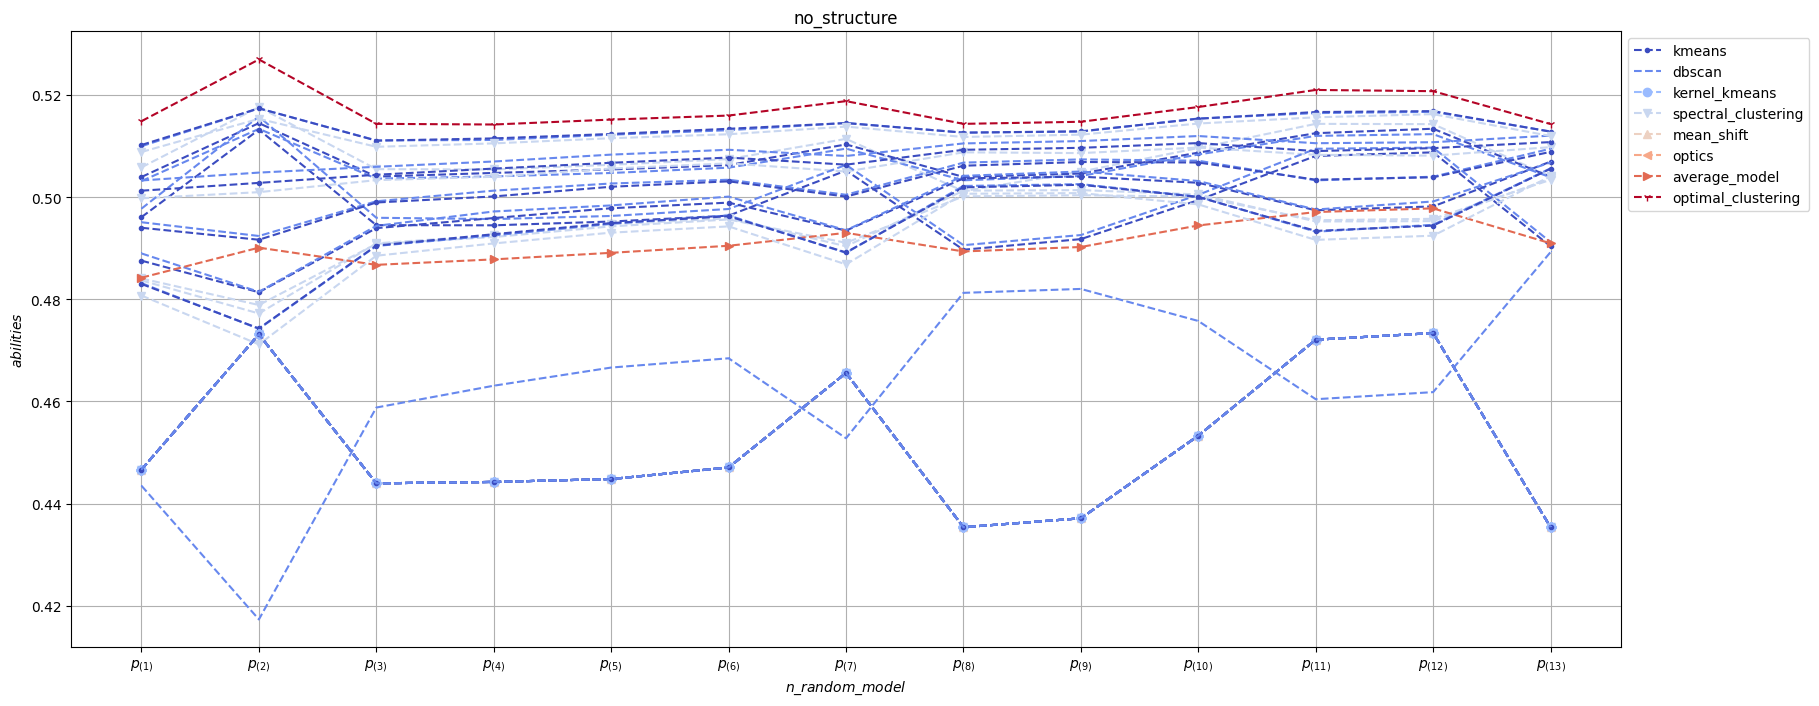

In [14]:
## by dataset
figs_dataset = {}
for name, content in datasets.items():
    _fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{("+k[1]+")}$")
                linestyle = '--'
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")
    ax.set_xlabel('$n\_random\_model$')
    ax.legend(handler_lines, models, loc='upper left', bbox_to_anchor=(1.00, 1.0))
    figs_dataset[name] = _fig
    plt.ioff()

In [15]:
## global plot
fig, axes = plt.subplots(len(datasets.keys()), 1, figsize=(20, 8*len(datasets)))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, (name, content) in zip(axes, datasets.items()):
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{("+k[1]+")}$")
                linestyle = '--'
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")

axes[-1].set_xlabel('$n\_random\_model$')
handler_lines = [Line2D([], [], color=param["color"], linestyle=param["linestyle"], marker=param["marker"]) for param in _params.values()]
axes[0].legend(handler_lines, models, loc='upper left', bbox_to_anchor=(1.00, 1.0))
plt.ioff()

## Save

In [ ]:
fig.savefig(str(file_path_simulation_plot)+".eps") # save eps format
fig.savefig(str(file_path_simulation_plot)+".png") # save png format

In [ ]:
for name, content in figs_dataset.items():
    content.savefig(str(file_path_plot_i_dataset).format(name)+".eps") # save eps format
    content.savefig(str(file_path_plot_i_dataset).format(name)+".png") # save png format